In [0]:
#'from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


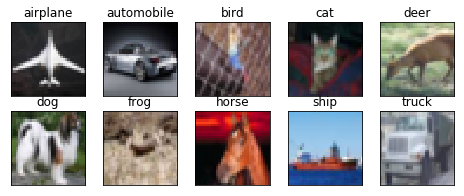

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
from keras.layers.advanced_activations import ReLU
from keras.layers import Concatenate,Input,Conv2D,SeparableConv2D, UpSampling2D, GlobalAveragePooling2D
from keras.models import Model
#Using functional model instead of Sequential
input_layer = Input(shape=(32, 32, 3,))

# Depthwise separable convolution 5x5
sep5_1 = SeparableConv2D(32, (5,5), strides=(1,1), border_mode='same')(input_layer)
sep5_1 = BatchNormalization()(sep5_1)
sep5_1 = ReLU()(sep5_1)

# Convolution 5x5
con5_1 = Conv2D(32, (5,5), strides=(1,1), border_mode='same')(sep5_1)
con5_1 = BatchNormalization()(con5_1)
con5_1 = ReLU()(con5_1)
con5_1 = Dropout(0.25)(con5_1)

# Convolution 5x5
con5_2 = Conv2D(32, (5,5), strides=(1,1), border_mode='same')(con5_1)
con5_2 = BatchNormalization()(con5_2)
con5_2 = ReLU()(con5_2)
con5_2 = Dropout(0.25)(con5_2)

skip1 = Concatenate(name='sk1')([sep5_1, con5_2])

# Depthwise separable convolution 5x5
sep5_2 = SeparableConv2D(32, (5,5), strides=(1,1), border_mode='same')(skip1)
sep5_2 = BatchNormalization()(sep5_2)
sep5_2 = ReLU()(sep5_2)


skip2 = Concatenate(name='sk2')([sep5_1, sep5_2])

#Maxpooling 
mp1 = MaxPooling2D(pool_size=(2, 2))(skip2)

mp1 = UpSampling2D(size=(2,2))(mp1)

# Depthwise separable convolution 3x3
sep3_1 = SeparableConv2D(32, (3,3), strides=(1,1), border_mode='same')(mp1)
sep3_1 = BatchNormalization()(sep3_1)
sep3_1 = ReLU()(sep3_1)

skip3 = Concatenate(name='sk3')([sep3_1, sep5_1, sep5_2])

# Convolution 5x5
con5_3 = Conv2D(32, (5,5), strides=(1,1), border_mode='same')(skip3)
con5_3 = BatchNormalization()(con5_3)
con5_3 = ReLU()(con5_3)
con5_3 = Dropout(0.25)(con5_3)

# Depthwise separable convolution 3x3
skip4 = Concatenate(name='sk4')([con5_2, con5_3, sep3_1, sep5_2])

sep3_2 = SeparableConv2D(32, (3,3), strides=(1,1), border_mode='same')(skip4)
sep3_2 = BatchNormalization()(sep3_2)
sep3_2 = ReLU()(sep3_2)


skip5 = Concatenate(name='sk5')([con5_2, con5_3, sep3_2, sep3_1, sep5_1, sep5_2])


# Depthwise separable convolution 5x5
sep5_3 = SeparableConv2D(32, (5,5), strides=(1,1), border_mode='same')(skip5)
sep5_3 = BatchNormalization()(sep5_3)
sep5_3 = ReLU()(sep5_3)

skip6 = Concatenate(name='sk6')([sep3_2, sep5_3, sep3_1, sep5_1, sep5_2])
mp2 = MaxPooling2D(pool_size=(2, 2))(skip6)

mp2 = UpSampling2D(size=(2,2))(mp2)

#----------------------------------------------------------------------

skip7 = Concatenate(name='sk7')([con5_3, mp2])

# Convolution 5x5
con5_4 = Conv2D(32, (5,5), strides=(1,1), border_mode='same')(skip7)
con5_4 = BatchNormalization()(con5_4)
con5_4 = ReLU()(con5_4)
con5_4 = Dropout(0.25)(con5_4)

skip8 = Concatenate(name='sk8')([con5_1, sep3_2, con5_4, sep5_2])

# Depthwise separable convolution 5x5
sep5_4 = SeparableConv2D(32, (5,5), strides=(1,1), border_mode='same')(skip8)
sep5_4 = BatchNormalization()(sep5_4)
sep5_4 = ReLU()(sep5_4)

skip9 = Concatenate(name='sk9')([con5_1, con5_2, con5_4, sep5_4, sep3_1])

# Convolution 3x3
con3_1 = Conv2D(32, (3,3), strides=(1,1), border_mode='same')(skip9)
con3_1 = BatchNormalization()(con3_1)
con3_1 = ReLU()(con3_1)
con3_1 = Dropout(0.25)(con3_1)

skip10 = Concatenate(name='sk10')([sep3_2, con5_2, con3_1, sep5_4, sep3_1, sep5_2, sep5_1])

# Depthwise separable convolution 5x5
sep5_5 = SeparableConv2D(32, (5,5), strides=(1,1), border_mode='same')(skip10)
sep5_5 = BatchNormalization()(sep5_5)
sep5_5 = ReLU()(sep5_5)

skip11 = Concatenate(name='sk11')([sep3_2, sep5_5, sep5_4, sep5_2])

#1x1x10 convolution before feeding it to global average pooling
layer_1 = Conv2D(10, (1,1), strides=(1,1), border_mode='same')(skip11)

#GAP
layer_2= GlobalAveragePooling2D()(layer_1)


#layer_2 = Flatten()(layer_2)
output = Activation('softmax')(layer_2)
model = Model(inputs=[input_layer], outputs=[output])
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(32, (5, 5), strides=(1, 1), padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), strides=(1, 1), padding="same")`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), strides=(1, 1), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(32, (5, 5), strides=(1, 1), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(32, (3, 3), strides=(1, 1), padding="same")`
/usr/local/lib/python3.6/dist-packages/ip

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_8 (SeparableCo (None, 32, 32, 32)   203         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 32, 32, 32)   128         separable_conv2d_8[0][0]         
__________________________________________________________________________________________________
re_lu_13 (ReLU)                 (None, 32, 32, 32)   0           batch_normalization_13[0][0]     
__________________________________________________________________________________________________
conv2d_7 (

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`
  if sys.path[0] == '':
W0619 01:32:04.664197 140719566186368 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and wil

Epoch 1/100
390/390 [==============================] - 74s 190ms/step - loss: 1.4642 - acc: 0.4673 - val_loss: 2.1291 - val_acc: 0.3826
Epoch 2/100
390/390 [==============================] - 68s 175ms/step - loss: 1.1086 - acc: 0.6057 - val_loss: 1.7173 - val_acc: 0.4721
Epoch 3/100
390/390 [==============================] - 69s 176ms/step - loss: 0.9697 - acc: 0.6588 - val_loss: 1.4240 - val_acc: 0.5383
Epoch 4/100
390/390 [==============================] - 69s 178ms/step - loss: 0.8947 - acc: 0.6836 - val_loss: 1.2180 - val_acc: 0.5700
Epoch 5/100
390/390 [==============================] - 70s 179ms/step - loss: 0.8273 - acc: 0.7085 - val_loss: 1.4057 - val_acc: 0.5738
Epoch 6/100
390/390 [==============================] - 70s 179ms/step - loss: 0.7744 - acc: 0.7263 - val_loss: 1.0189 - val_acc: 0.6494
Epoch 7/100
390/390 [==============================] - 70s 179ms/step - loss: 0.7300 - acc: 0.7428 - val_loss: 0.9566 - val_acc: 0.6500
Epoch 8/100
390/390 [===========================

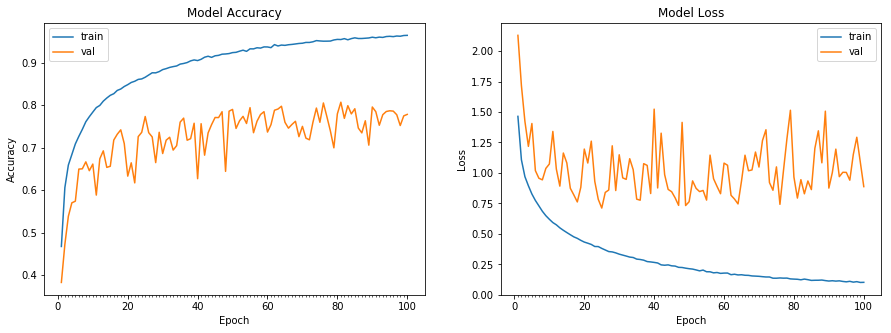

Accuracy on test data is: 77.81


In [10]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

80.68 % accuracy in the 81st epoch